In [1]:
import numpy as np
import netCDF4 as nc
import xarray as xr
import datetime as dt
import copy
import datetime as dt
from scipy import stats
import esmpy as ESMF
import pandas as pd
from matplotlib.path import Path
import matplotlib.patches as mpatches
import matplotlib.dates as pltd
import matplotlib.pyplot as plt 

Could not save font_manager cache [Errno 28] No space left on device


In [2]:
def convert_nep_time(time):
    ref = dt.datetime(1993,1,1,0,0,0)
    date_vals = np.zeros(len(time))
    for nt in range(len(time)):
        day_time = ref + dt.timedelta(days=float(time[nt]))
        date_vals[nt] = pltd.date2num(day_time)
            
    return date_vals

In [3]:
def create_regrid_obj(src_clon,src_clat,src_lsm,dst_clon,dst_clat):
    # Make 2D coordinates for remapping
    if len(src_clon.shape)<2:
        src_clon,src_clat = np.meshgrid(src_clon,src_clat)
        
    if len(dst_clon.shape)<2:
        dst_clon,dst_clat = np.meshgrid(dst_clon,dst_clat)
    
    sourcegrid = ESMF.Grid(np.array(src_lsm.shape), staggerloc = ESMF.StaggerLoc.CORNER,coord_sys = ESMF.CoordSys.SPH_DEG)
    sourcegrid.add_item(ESMF.GridItem.MASK,[ESMF.StaggerLoc.CENTER])
    grid_mask = sourcegrid.get_item(ESMF.GridItem.MASK)
    grid_mask[...] = src_lsm.astype(np.int32) 

    source_lon = sourcegrid.get_coords(0, staggerloc=ESMF.StaggerLoc.CORNER)
    source_lat = sourcegrid.get_coords(1, staggerloc=ESMF.StaggerLoc.CORNER)

    source_lon[...] = src_clon
    source_lat[...] = src_clat

    sourcefield = ESMF.Field(sourcegrid, name = 'src_field')
    srcfracfield = ESMF.Field(sourcegrid, 'srcfracfield')
        
    destgrid = ESMF.Grid(np.array(dst_clon[1:,1:].shape), staggerloc = ESMF.StaggerLoc.CORNER, coord_sys = ESMF.CoordSys.SPH_DEG)

    dest_clon = destgrid.get_coords(0,staggerloc=ESMF.StaggerLoc.CORNER)
    dest_clat = destgrid.get_coords(1,staggerloc=ESMF.StaggerLoc.CORNER)

    dest_clon[...] = dst_clon
    dest_clat[...] = dst_clat

    destfield = ESMF.Field(destgrid, name = 'dest_field')

    # DEFINE INTERPOLATION FUNCTION
    regrid = ESMF.Regrid(sourcefield, destfield,regrid_method = ESMF.RegridMethod.CONSERVE,
                     src_mask_values=np.array([0], dtype=np.int32),src_frac_field=srcfracfield,
                     norm_type=ESMF.NormType.FRACAREA,unmapped_action = ESMF.UnmappedAction.IGNORE)

    return sourcefield, destfield, regrid

In [4]:
def get_model_ds(src_model):
    
    # CONSTRUCT FILE NAME
    ncfil = (mod_dict[src_model]['dir'] 
            + mod_dict[src_model]['file'])
            
    print(ncfil)
            
    # Open as xarray dataset
    ds = xr.open_dataset((ncfil),decode_times=False)
        
    return ds
                

In [5]:
def get_coords(src_model,ds):
 
    if src_model == 'ESA':
        
        lon = ds.lon.values
        lat = ds.lat.values
        
        clon = (lon[:-1] + lon[1:])/2
        clat = (lat[:-1] + lat[1:])/2            
        clon = np.insert(np.insert(clon,0,2*clon[0]-clon[1]),-1,2*clon[-1]-clon[-2])
        clat = np.insert(np.insert(clat,0,2*clat[0]-clat[1]),-1,2*clat[-1]-clat[-2])
        
        lons,lats = np.meshgrid(lon,lat)

        
    elif src_model == 'NEP':
 
        lon = nep_lon
        lat = nep_lat
        clon = nep_clon 
        clat = nep_clat
        

    return lat,lon,clat,clon


In [6]:
def plot_clim(comp_mod,ytemp):
    print(ytemp.shape)
    if len(regions) == 1:
        ax = axs[0]
    else: 
        ax = axs[nreg,0]
    
    # plot the climatology
    ax.plot(np.arange(12),ytemp,'-o',color=mod_dict[comp_mod]['color'],label=mod_dict[comp_mod]['title'])
    
    if comp_mod == 'ESA':
        y_max = np.max((esa_clim_reg,nep_clim_reg))
        y_min = np.min((esa_clim_reg,nep_clim_reg))
        
        yrange = y_max-y_min
        
        new_y_min = y_min-.05*yrange
        new_y_max = y_max + .2*yrange
            
        ax.set_ylim(new_y_min,new_y_max)
        
        if nreg == 0: 
            ax.set_title('Climatology', fontsize=20)
            ax.legend()
        elif nreg == 3:
            ax.set_ylabel('Surface Chlorophyll (mg m$^{-3}$)',fontsize=20, y=1, labelpad=10, ha='center')    
         
        r_x = .3; r_y = .02   
        r_val = stats.pearsonr(nep_clim_reg, esa_clim_reg)[0]
        print('clim:',stats.pearsonr(nep_clim_reg, esa_clim_reg))
        ax.text(r_x,r_y,('R = ' + f'{r_val:.2f}'),transform=ax.transAxes,fontsize=16)
        ax.text(.02,.88,region_dict[region]['title'],transform=ax.transAxes,fontsize=18)
        ax.tick_params(axis='y', which='major', labelsize=15)
        
        if nreg == len(regions)-1:
            ax.set_xlabel('Month',fontsize=15)
            ax.set_xlim(0,11)
            ax.set_xticks(np.arange(0,12,2))
            ax.set_xticklabels(months[::2],fontsize=15)

In [7]:
def plot_ts(comp_mod,xtim,ychl):
    
    if len(regions) == 1:
        ax = axs[1]
    else: 
        ax = axs[nreg,1]
        
    ax.plot(xtim,ychl,color=mod_dict[comp_mod]['color'],zorder=mod_dict[comp_mod]['zorder'])
    
    
    if comp_mod == 'ESA':
        
        ymin, ymax = ax.get_ylim()
        yrange = np.max((abs(ymin),abs(ymax)))
        
        if ts_type == 'anomaly':
            y_min = -yrange
            y_max = yrange
        else: 
            y_min = -.1
            y_max = yrange + 1
            
        ax.set_ylim(y_min,y_max)
    
        ax.fill_between(xtim, y_min, y_max, where=(oni <= -.5) & (oni >= min(oni)), color='blue',alpha=0.05,zorder=5)
        ax.fill_between(xtim, y_min, y_max, where=(oni >= 0.5) & (oni <=max(oni) ), color='red', alpha=0.05,zorder=5)
        ax.plot([pltd.date2num(dt.datetime(1998,1,1)),pltd.date2num(dt.datetime(2019,12,31))],np.zeros(2),':',color='gray')    
    
        ax.tick_params(axis='y', which='major', labelsize=15)
        corr = stats.pearsonr(nep_ts, esa_ts)
        
        if nreg == 0:
            ax.set_title('Monthly Anomalies',fontsize=20)
            handles, labels = ax.get_legend_handles_labels()

            # manually define a new patch 

            patch1 = mpatches.Patch(color='blue', alpha= 0.1, label='cold ONI')
            patch2 = mpatches.Patch(color='red', alpha= 0.1, label='warm ONI')
            # handles is a list, so append manual patch
            handles.append(patch1) 
            handles.append(patch2) 

            # plot the legend
            ax.legend(handles=handles, ncol = 2, bbox_to_anchor=(0.6,0.25), framealpha=1, prop={'size': 14})
    
        r_x = 0.8; r_y = .02
        
        r_val = stats.pearsonr(nep_ts, esa_ts)[0]
        # print statistics ... somewhere? legend method maybe
        print('anomaly:',stats.pearsonr(nep_ts, esa_ts))
        t1 = ax.text(r_x, r_y,'R = %.2f' % (r_val), fontsize=16, transform = ax.transAxes, zorder=18)

        if nreg == len(regions)-1:
            ax.xaxis_date()
            ax.set_xlim(pltd.date2num(dt.datetime(1998,1,1)),pltd.date2num(dt.datetime(2019,12,31)))
            ax.tick_params(axis='x', which='major', labelsize=15)

In [8]:
txt_file = '/work/role.medgrp/NEP/plotting/Figure_18/detrend_nino34_1993-2019_anom.csv'
df = pd.read_csv(txt_file,sep=' ')
oni = df.ANOM[12*(1998-1993):]

In [9]:
# NEP Grid
nep_grd_fil = '/work/role.medgrp/NEP/plotting/shared_files/NEP_ocean_static_nomask.nc'
grd_fid = nc.Dataset(nep_grd_fil)

# Extracting tracer lat/lon from the supergrid
nep_lat = grd_fid.variables['geolat'][:]
nep_lon = grd_fid.variables['geolon'][:]

# Extracting tracer corner lat/lon from the supergrid - needed for regridding and pcolor plots
nep_clat = grd_fid.variables['geolat_c'][:]
nep_clon = grd_fid.variables['geolon_c'][:]

nep_depth = grd_fid.variables['deptho'][:]

lsm = grd_fid.variables['wet'][:]
lsm[lsm<1]=0 
lsm[lsm>1]=1 

nep_area = grd_fid.variables['areacello'][:].squeeze()
nep_area[lsm<.5]=0

nep_mask = copy.deepcopy(lsm)

chuk_mask = nep_lat>66

coors=np.hstack((nep_lon.reshape(-1, 1), nep_lat.reshape(-1,1)))

In [10]:
shelf_criteria = {'0-50m':   {'dep_min':0,'dep_max':50},
                  '0-500m':  {'dep_min':0,'dep_max':500},
                  '0-1000m': {'dep_min':0,'dep_max':1000},
                  '50-500m': {'dep_min':50,'dep_max':500},
                  '50-1000m':{'dep_min':50,'dep_max':1000},
                  '50-2000m': {'dep_min':50,'dep_max':2000},}

mod_dict = {'ESA':{'dir':'/work/role.medgrp/NEP/plotting/Figure_18/',
                   'file':'ESACCI-OC-L3S-CHLOR_A-MERGED-1M_MONTHLY_4km_GEO_PML_OCx-1998-2019-fv6.0_nep.nc',
                   'var':'chlor_a','unit_fact':1,'title':'OC-CCI',
                   #'color':'navy','zorder':25},
                   'color':'darkorange','zorder':25},
            
            'NEP':{'dir':'/work/role.medgrp/NEP/plotting/Figure_18/',
                   'file':'nep_chlos_1998-2019_monthly_ts.nc',
                   'var':'chlos','unit_fact':1000*1000,'title':'NEP10k',
                   #'color':'darkorange','zorder':30},}
                   'color':'green','zorder':30},}

region_dict = {'goc':{'title':'Gulf of California', 
                      #'title':'Gulf of California', 
                      'points': [(244,32),(250,23),(254,23),(247,32),(244,32)]},
               'sccs':{'title':'SCCS',
                       #'title':'Southern CCS',
                       'points': [(243,32.53),   (243,34.45),   (238,34.45),  (238,32.53),   (243,32.53)]},
               'cccs':{'title':'CCCS',
                       #'title':'Central CCS',
                       'points': [(240,34.45),   (240,40.44),   (234,40.44),  (234,34.45),   (240,34.45)]},
               'nccs':{'title':'NCCS',
                       #'title':'Northern CCS',
                       'points': [(236.5,40.44), (236.5,48.4),  (235.34,48.4),(231.9,46),    (231.9,40.44),
                                  (236.5,40.44)]},
               'bc':  {'title':'BC',
                       #'title':'British Columbia',
                       'points': [(240,48.14),   (230.5,54.76), (221.1,53.46),(231.9,46),    (235.34,48.4),
                                  (240,48.14)]},
               'goa': {'title':'GOA',
                       #'title':'Gulf of Alaska',
                       'points': [(230.5,54.76), (220,61.55),   (207.4,61.51),(201.74,56.62),(199.5,55.5),
                                  (210,53.46),   (221.1,53.46), (230.5,54.76)]},
               'ber': {#'title':'Bering Sea',
                       'title':'BS',
                       'points': [(203.59,58.91),(201.31,65.44),(191,65.76),  (169.14,53.18),(173.18,52.81),
                                  (179.51,51.78),(186.81,52.16),(193.05,53.65),(199.2,55.63),(202.98,57.47),
                                  (203.59,58.91),]}
              }

chl_dict = {'abs':{'vmin':0,'vmax':2, 'cbar_n':17, 'inc':.25,
                   'cbar_tit':'abs', 'units':' (mg m$^{-3}$)','cbar_xticks':[-2,-.5,-.1,0,.1,.5,2],
                   'dif_range':1, 'dif_cbar_n':17,'dif_inc':.125},
            'log':{'vmin':-1.1,'vmax':0.9, 'cbar_n':17, 'inc':.1,
                   'cbar_tit':'log$_{10}$', 'units':'','cbar_xticks':np.linspace(-np.log10(4),np.log10(4),5),
                   'dif_range':np.log10(4), 'dif_cbar_n':17,'dif_inc':.25}}

plot_labels = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r']

In [11]:
def create_regrid_obj():
    # ESACCI is higher resolution than NEP so ESACCI is source; NEP is destination
    
    sourcegrid = ESMF.Grid(np.array((len(lat),len(lon))), staggerloc = ESMF.StaggerLoc.CORNER,coord_sys = ESMF.CoordSys.SPH_DEG)
    sourcegrid.add_item(ESMF.GridItem.MASK,[ESMF.StaggerLoc.CENTER])
    grid_mask = sourcegrid.get_item(ESMF.GridItem.MASK)
    #grid_mask[...] = lsm.astype(np.int32)

    source_lon = sourcegrid.get_coords(0, staggerloc=ESMF.StaggerLoc.CORNER)
    source_lat = sourcegrid.get_coords(1, staggerloc=ESMF.StaggerLoc.CORNER)

    Xn, Yn = np.meshgrid(clon,clat)
    
    source_lon[...] = Xn
    source_lat[...] = Yn

    sourcefield = ESMF.Field(sourcegrid, name = 'ESACCI data')
    srcfracfield = ESMF.Field(sourcegrid, 'srcfracfield')
    
    destgrid = ESMF.Grid(np.array(nep_lon.shape), staggerloc = ESMF.StaggerLoc.CORNER, coord_sys = ESMF.CoordSys.SPH_DEG)

    dest_lon = destgrid.get_coords(0,staggerloc=ESMF.StaggerLoc.CORNER)
    dest_lat = destgrid.get_coords(1,staggerloc=ESMF.StaggerLoc.CORNER)

    dest_lon[...] = nep_clon
    dest_lat[...] = nep_clat

    destfield = ESMF.Field(destgrid, name = 'NEP grid')

    # DEFINE INTERPOLATION FUNCTION
    regrid = ESMF.Regrid(sourcefield, destfield,regrid_method = ESMF.RegridMethod.CONSERVE,
                     src_mask_values=np.array([0], dtype=np.int32),src_frac_field=srcfracfield,
                     norm_type=ESMF.NormType.FRACAREA,unmapped_action = ESMF.UnmappedAction.IGNORE)
    
    return sourcefield, destfield, regrid

/work/role.medgrp/NEP/plotting/Figure_18/nep_chlos_1998-2019_monthly_ts.nc
/work/role.medgrp/NEP/plotting/Figure_18/ESACCI-OC-L3S-CHLOR_A-MERGED-1M_MONTHLY_4km_GEO_PML_OCx-1998-2019-fv6.0_nep.nc
0
20
40
60
80
100
120
140
160
180
200
220
240
260
Done with regrid

NaNs masked


/vftmp/Utheri.Wagura/pid68683/ipykernel_74718/479577091.py:56: RuntimeWarning: Mean of empty slice
  nep_clim = np.nanmean(nep_clim,axis=0) # use nanmean?
/vftmp/Utheri.Wagura/pid68683/ipykernel_74718/479577091.py:67: RuntimeWarning: Mean of empty slice
  esa_clim = np.nanmean(esa_clim,axis=0) # use nanmean?


ber 0
(12,)
(12,)
clim: PearsonRResult(statistic=0.5785966443817055, pvalue=0.048728930958413984)
anomaly: PearsonRResult(statistic=-0.006949364262054086, pvalue=0.9105226177713169)
goa 1
(12,)
(12,)
clim: PearsonRResult(statistic=0.8998960828981359, pvalue=6.677834533135447e-05)
anomaly: PearsonRResult(statistic=0.35340737507381725, pvalue=3.49152007842276e-09)
bc 2
(12,)
(12,)
clim: PearsonRResult(statistic=0.9004512248071005, pvalue=6.500960425405493e-05)
anomaly: PearsonRResult(statistic=0.3464081663411363, pvalue=7.392277573041789e-09)
nccs 3
(12,)
(12,)
clim: PearsonRResult(statistic=0.8893916708246873, pvalue=0.00010799409842705597)
anomaly: PearsonRResult(statistic=0.562907731513151, pvalue=1.814709276008435e-23)
cccs 4
(12,)
(12,)
clim: PearsonRResult(statistic=0.8153589142471185, pvalue=0.0012284186122973784)
anomaly: PearsonRResult(statistic=0.37250958039970955, pvalue=4.0983497964952453e-10)
sccs 5
(12,)
(12,)
clim: PearsonRResult(statistic=0.9893032964545843, pvalue=1.0832

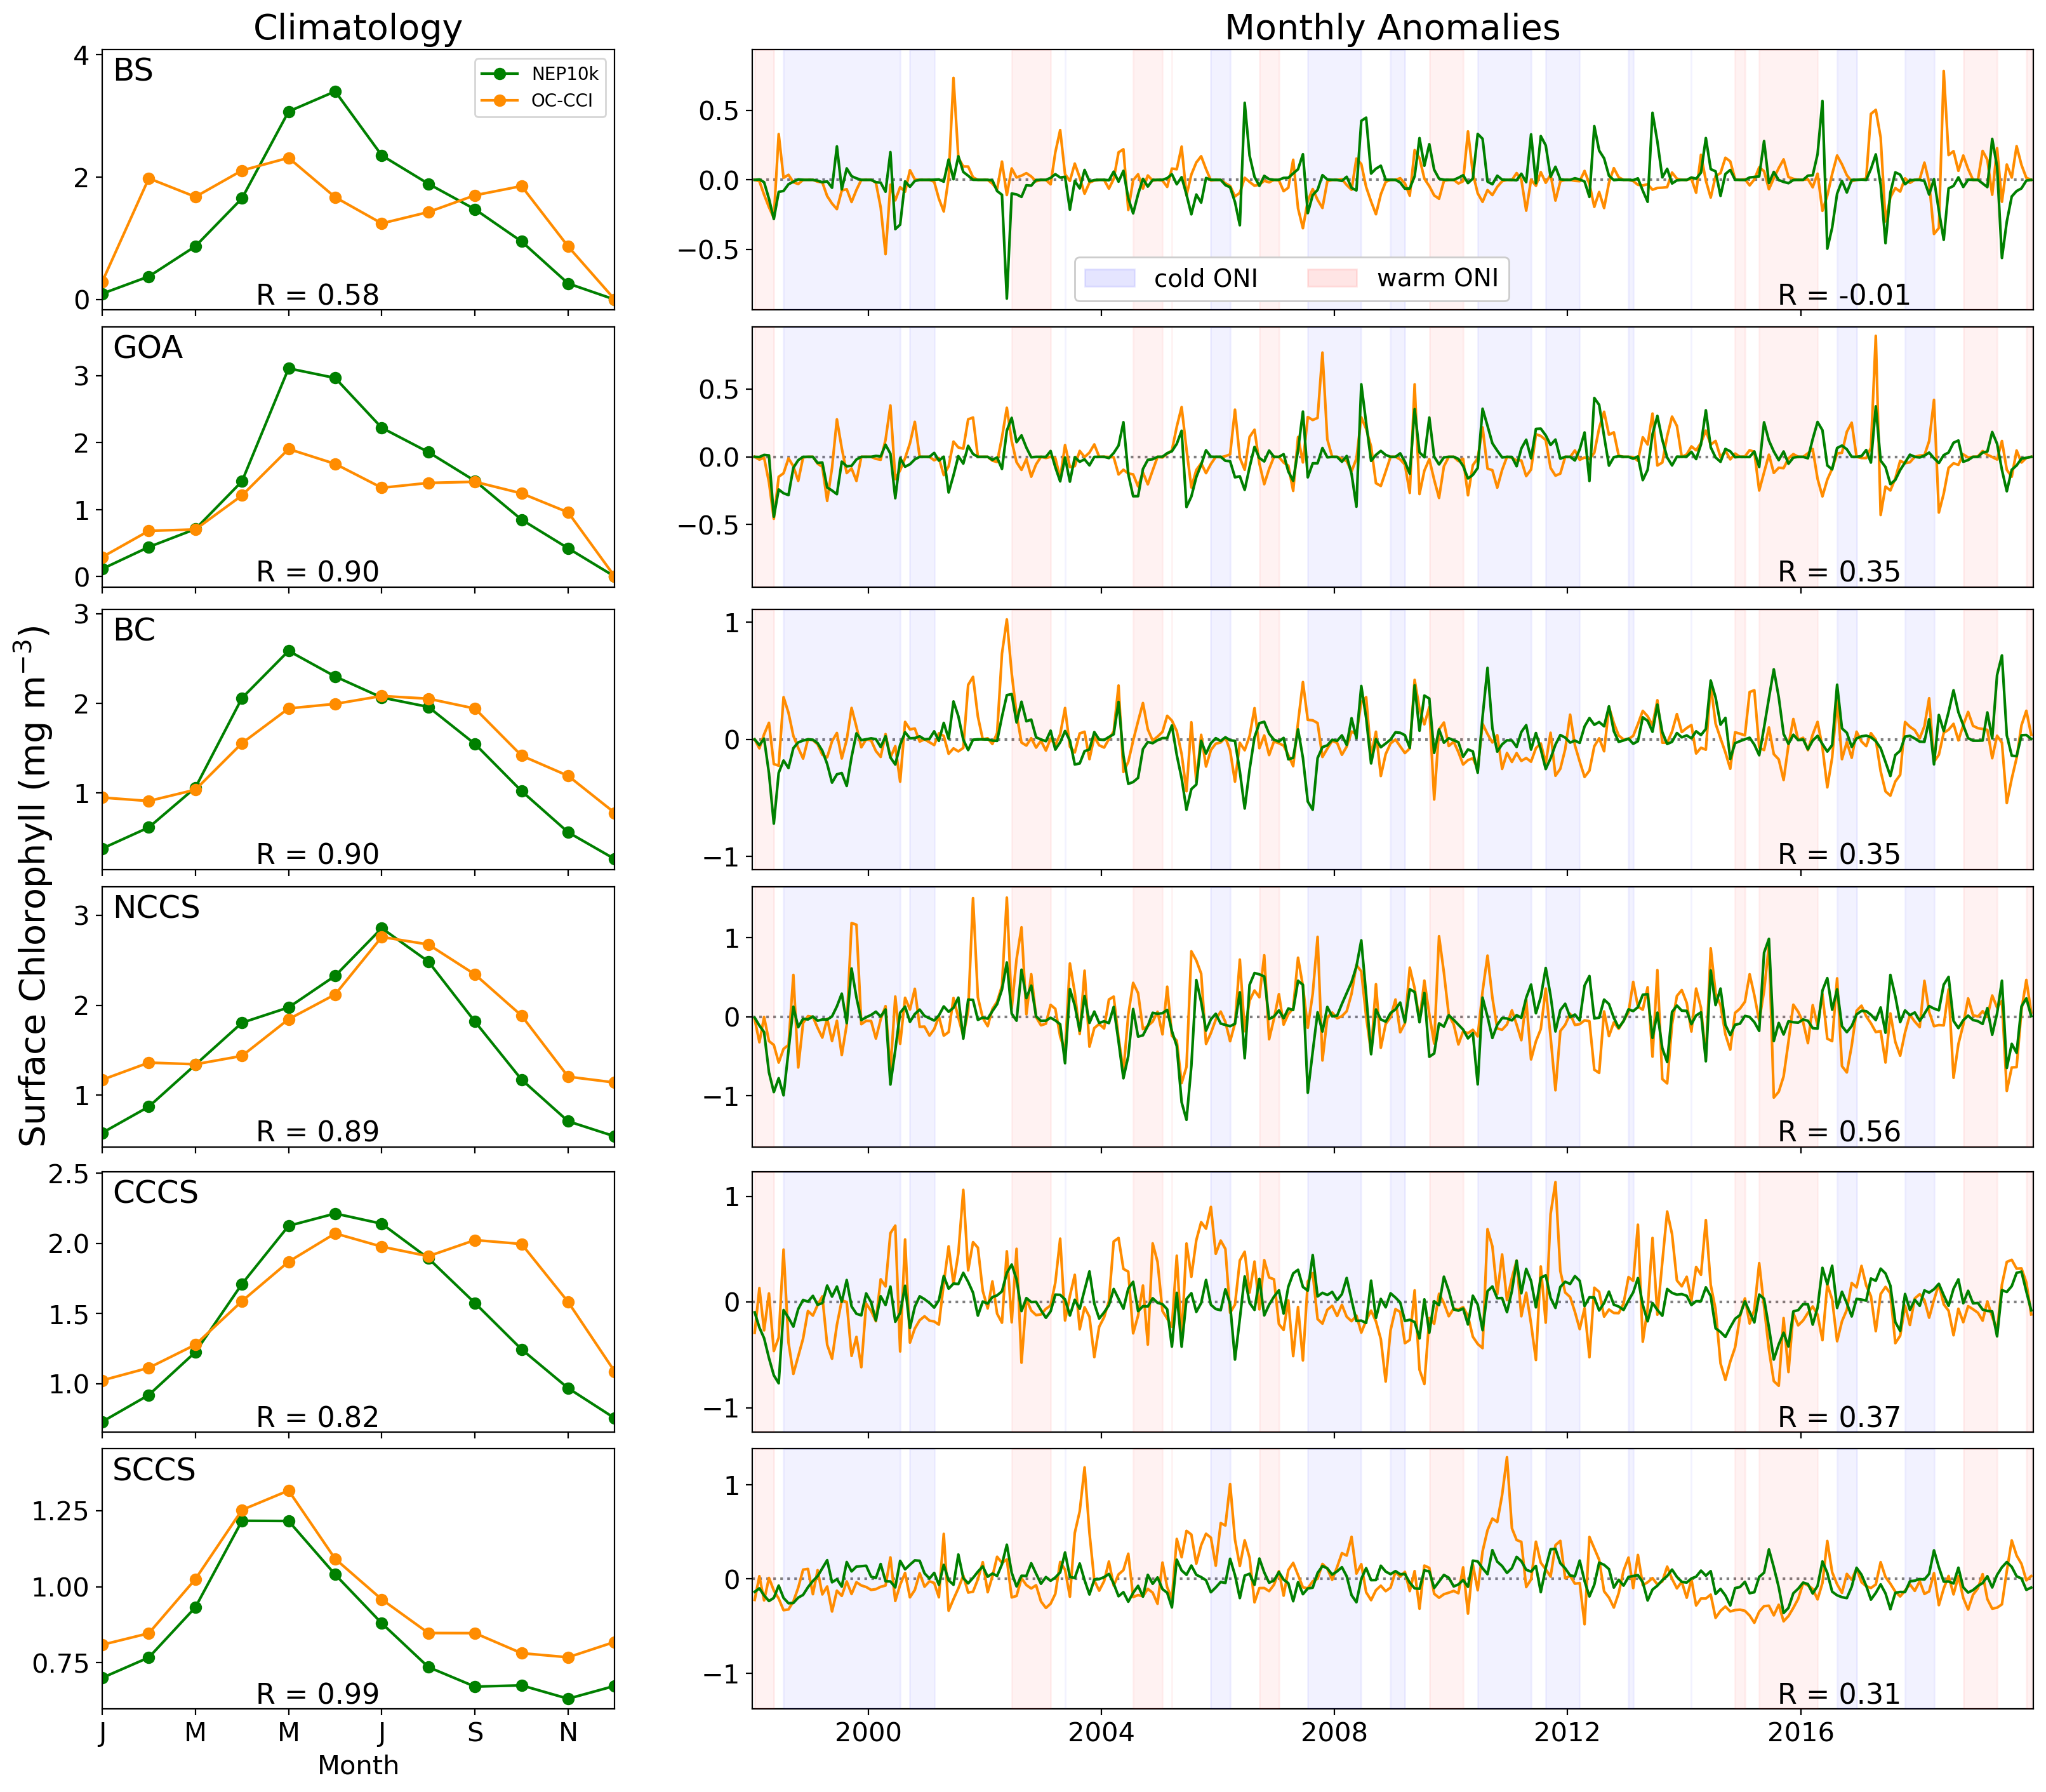

In [12]:
regions = ['ber', 'goa', 'bc', 'nccs','cccs','sccs']
scrit = '0-500m'

months = ['J','F','M','A','M','J','J','A','S','O','N','D']

ts_type = 'anomaly'

widths = [2, 5]
gs_kw = dict(width_ratios=widths, wspace=.06)
fig, axs = plt.subplots(ncols=2, nrows=6, constrained_layout=True, sharex='col', 
                         gridspec_kw=gs_kw, figsize=(16,14),dpi=200)

# Open as xarray dataset
ds_nep = get_model_ds('NEP')   
NEP_chl = 1000*1000*ds_nep['chlos'].values.squeeze()
NEP_chl[:,chuk_mask]=None
plt_time = convert_nep_time(ds_nep['time'].values.squeeze())
    
ds_esa = get_model_ds('ESA')
ESA_chl = ds_esa['chlor_a'].values.squeeze()
lat,lon,clat,clon = get_coords('ESA',ds_esa)
lons,lats = np.meshgrid(lon,lat)
sourcefield, destfield, regrid = create_regrid_obj()
        
# Get area for weighted statistics 
const_offset = 500
ESA_val_out_store = np.zeros((ESA_chl.shape[0],nep_lat.shape[0],nep_lon.shape[1]))
for nt in range(ESA_chl.shape[0]):
    if nt%20 == 0:
        print(nt) # Tracking progress
    sourcefield.data[...] = ESA_chl[nt,:].squeeze() + const_offset
    destfield = regrid(sourcefield, destfield)   
    tmp_val = copy.deepcopy(destfield.data)
    tmp_val[tmp_val==0] = np.nan
    ESA_val_out_store[nt,:] = tmp_val - const_offset
    
ESA_val_out_store[:,nep_mask==0]=np.nan
ESA_val_out_store[:,chuk_mask]=None
    
print('Done with regrid')    

# not_nan_idx method identifies where both products have valid data. multiply by -1, add 1 will give nan locations
not_nan_idx = ~np.isnan(ESA_val_out_store)*~np.isnan(NEP_chl)
nan_idx = (-1*not_nan_idx+1).astype(bool)
    
NEP_chl[nan_idx]=np.nan
ESA_val_out_store[nan_idx]=np.nan
print()
print('NaNs masked')
depth_criteria = (nep_depth<shelf_criteria[scrit]['dep_max'])*(nep_depth>shelf_criteria[scrit]['dep_min'])
                
if ts_type == 'anomaly':
        
    # caculate the anomaly for NEP
    nep_clim = NEP_chl.reshape((-1,12,NEP_chl.shape[1],NEP_chl.shape[2]))
    nep_clim = np.nanmean(nep_clim,axis=0) # use nanmean?
    #nep_med = NEP_chl.reshape((-1,12,NEP_chl.shape[1],NEP_chl.shape[2]))
    #nep_med = np.nanmedian(nep_med,axis=0) # use nanmean?
    nep_anom = NEP_chl.reshape((-1,12,NEP_chl.shape[1],NEP_chl.shape[2])) - nep_clim[np.newaxis,:]
    nep_anom = nep_anom.reshape(NEP_chl.shape)
    #nep_anom = NEP_chl.reshape((-1,12,NEP_chl.shape[1],NEP_chl.shape[2])) - nep_med[np.newaxis,:]
    #nep_anom = nep_anom.reshape(NEP_chl.shape)
    NEP_chl = copy.deepcopy(nep_anom)
        
    # caculate the anomaly for ESA
    esa_clim = ESA_val_out_store.reshape((-1,12,ESA_val_out_store.shape[1],ESA_val_out_store.shape[2]))
    esa_clim = np.nanmean(esa_clim,axis=0) # use nanmean?
    #esa_med = ESA_val_out_store.reshape((-1,12,ESA_val_out_store.shape[1],ESA_val_out_store.shape[2]))
    #esa_med = np.nanmean(esa_med,axis=0) # use nanmean?
    esa_anom = ESA_val_out_store.reshape((-1,12,ESA_val_out_store.shape[1],ESA_val_out_store.shape[2])) - esa_clim[np.newaxis,:]
    esa_anom = esa_anom.reshape(ESA_val_out_store.shape)
        
    #esa_anom = ESA_val_out_store.reshape((-1,12,ESA_val_out_store.shape[1],ESA_val_out_store.shape[2])) - esa_med[np.newaxis,:]
    #esa_anom = esa_anom.reshape(ESA_val_out_store.shape)
    ESA_val_out_store = copy.deepcopy(esa_anom)
        
for region,nreg in zip(regions,range(len(regions))):
    print(region,nreg)
        
    # define regional values
    poly_path=Path(np.array(region_dict[region]['points']))
    poly_mask = poly_path.contains_points(coors).reshape(nep_lon.shape[0],nep_lat.shape[1])
    region_mask = (poly_mask==1)*depth_criteria
                
    tmp_area = np.ma.where(region_mask,nep_area,np.nan)
    total_area = np.nansum(tmp_area)   
    area_weight = tmp_area/total_area
 
    tmp_nep_chl = copy.deepcopy(NEP_chl)
    tmp_nep_chl[:,~region_mask] = np.nan
        
    tmp_nep_chl_clim = copy.deepcopy(nep_clim)
    tmp_nep_chl_clim[:,~region_mask] = np.nan
        
    nep_ts = np.nansum(area_weight*tmp_nep_chl,axis=(2,1))
    nep_clim_reg = np.nansum(area_weight*tmp_nep_chl_clim,axis=(2,1))
        
    plot_clim('NEP',nep_clim_reg)
    plot_ts('NEP',plt_time,nep_ts)
        
    tmp_esa_chl = copy.deepcopy(ESA_val_out_store)
    tmp_esa_chl[:,~region_mask] = np.nan
        
    tmp_esa_chl_clim = copy.deepcopy(esa_clim)
    tmp_esa_chl_clim[:,~region_mask] = np.nan
        
    esa_ts = np.nansum(area_weight*tmp_esa_chl,axis=(2,1))
    esa_clim_reg = np.nansum(area_weight*tmp_esa_chl_clim,axis=(2,1))
        
    plot_clim('ESA',esa_clim_reg)
    plot_ts('ESA',plt_time,esa_ts)
        
                
# save figure object at this level
save_str = 'Figure_18_Regional_surface_chl_timeseries_' + scrit 
fig.savefig(save_str)